In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
from numpy import loadtxt, corrcoef, delete, array, concatenate, vstack, ones, triu, where, linspace
from numpy.linalg import lstsq
pylab.rcParams['figure.figsize'] = (10.0, 10.0)

In [2]:
BIG_CORRELATION = 0.9

In [3]:
dataset = loadtxt('lab1.csv', skiprows=1, delimiter=',')
y = dataset[:, 0]
xs = dataset[:, 1:].transpose()

In [4]:
worst_pairs = where(triu(abs(corrcoef(xs)), 1) > BIG_CORRELATION)
correlations = abs(corrcoef(y, xs))[0][1:]
worst = [i if correlations[i] < correlations[j] else j for i, j in zip(*worst_pairs)]
xs = delete(xs, worst, axis=0)

In [5]:
sequences = concatenate([xs]+[xs[i]*xs[i:] for i in range(xs.shape[0])])

In [6]:
best = abs(corrcoef(y, sequences)[0][1:]).argmax()
x = sequences[best]

In [7]:
regression_coefficients = lstsq(vstack([x, ones(x.size)]).T, y)[0]
a, b = regression_coefficients
residuum = y - (a * x + b)

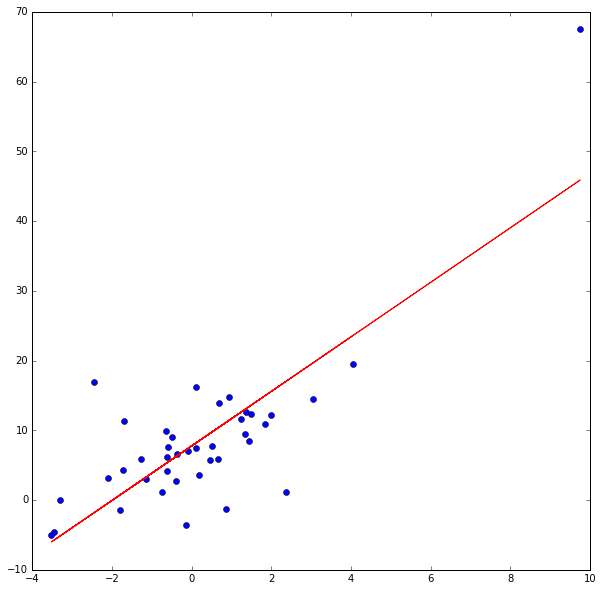

In [8]:
plt.plot(x, y, 'o', label='Original data')
plt.plot(x, a * x + b, 'r', label='Fitted line')
plt.show()

In [9]:
best_residuum_regressor = corrcoef(residuum, sequences)[0][1:].argmax()
r = sequences[best_residuum_regressor]

In [10]:
advanced_regression_coefficients = lstsq(vstack([x, r, ones(x.size)]).T, y)[0]
c, d, e = advanced_regression_coefficients

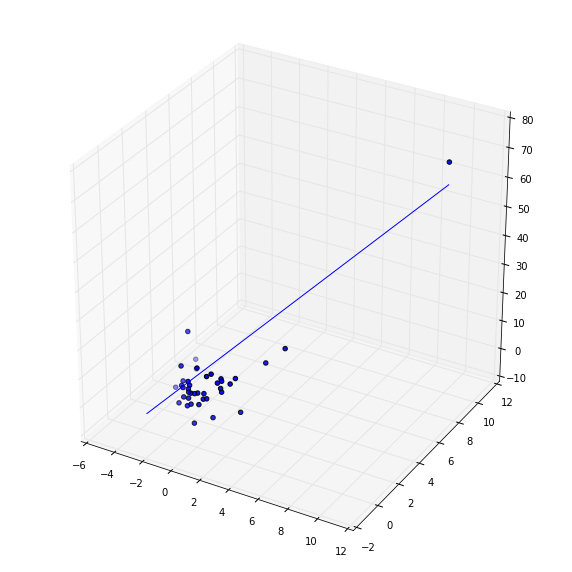

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, r, y)
x_grid=linspace(x.min(), x.max(), 100)
r_grid=linspace(r.min(), r.max(), 100)
ax.plot(x_grid, r_grid, c * x_grid + d * r_grid + e)
plt.show()

In [12]:
assert ((y - (x*c + r*d + e))**2).sum() < ((y - (x*a + b))**2).sum()